# Making normalized distributions
- processes an `events[year][ch][sample]` object using `make_events_dict()` per defined region
- plots normalized distributions of a chosen sample for a chosen region

In [475]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [476]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [533]:
# define your regions here
presel = {
    
#     ##### signal-like region
#     "LepIsolation": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#         },
#     },          
    
#     ##### QCD-like region
#     "LepIsolationInv": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",    
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#         },
#     },
    
    ##### signal region
    "Signal region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score>0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score>0.9) )",                    
        },
    },
    
    ##### QCD control region
    "QCD control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score<0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",                    
        },
    }, 
    
#     ##### QCD control region
#     "QCD new samples": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
# #             "tagger": " ( ( inclusive_score<0.9) )",        
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
# #             "tagger": " ( ( inclusive_score<0.9) )",                    
#         },
#     },
    
#     ##### QCD control region
#     "QCD old samples": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
# #             "tagger": " ( ( inclusive_score<0.9) )",        
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
# #             "tagger": " ( ( inclusive_score<0.9) )",                    
#         },
#     },     
    
#     ##### WJets control region
#     "WJets control region": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
#             "nbjets": "( (n_bjets_L == 0) )",     
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "nbjets": "( (n_bjets_L == 0) )",             
#         },
#     }, 
    
#     ##### TTbar control region
#     "TTbar control region": {
#         "mu": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "tagger": " ( ( inclusive_score<0.9) )",        
#             "nbjets": "( (n_bjets_T > 0) )",     
#         },
#         "ele": {
#             "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "tagger": " ( ( inclusive_score<0.9) )",            
#             "nbjets": "( (n_bjets_T > 0) )",     
#         },
#     },
}

In [534]:
weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

samples = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [592]:
from make_hists import make_events_dict

years = ["2017", "2016", "2016APV", "2018"]

channels = ["ele"]    # currently supports processing a single channel at a time

events_dict = {}
for ch in channels:
    for region in presel:

        if "QCD new samples" in region:
            samples_dir = f"../eos/Sep12_QCD_"   
        elif "QCD" in region or "LepIsolationInv" in region:
            samples_dir = f"../eos/Jul12QCD_"
        elif "WJets" in region:
            samples_dir = f"../eos/Jul15_region_wjets_"            
        else:
            samples_dir = f"../eos/Apr12_presel_"

        events_dict[region] = make_events_dict(years, channels, samples_dir, samples, presel[region], weights)

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 13875 events
applying tagger selection on 12665 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 6029 events
tot event weight 47.122270795594325 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 5972 events
applying tagger selection on 3009 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 128 events
tot event weight 0.8194615210008462 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in p

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 8943 events
applying tagger selection on 4419 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 193 events
tot event weight 2.6063224619763954 

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying pres

applying tagger selection on 1781 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 88 events
tot event weight 0.3066647893356673 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 9055 events
applying tagger selection on 7855 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 4274 events
tot event weight 35.01883210223091 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying w

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 17126 events
applying tagger selection on 7827 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 7459 events
tot event weight 291.3703009090042 

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying pre

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 998 events
applying tagger selection on 511 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 482 events
tot event weight 0.049819522027570444 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets

# Plotting

In [516]:
color_dict = {
    "LepIsolationInv": "grey",
    "LepIsolation": "purple",
    "Signal region": "red",
    "QCD control region": "orange",
    "WJets control region": "green",
    "TTbar control region": "blue",
    
    "QCD old samples": "green",
    "QCD new samples": "orange",
    
}

nice_ch = {
    "mu": "MUON",
    "ele": "ELECTRON"
}

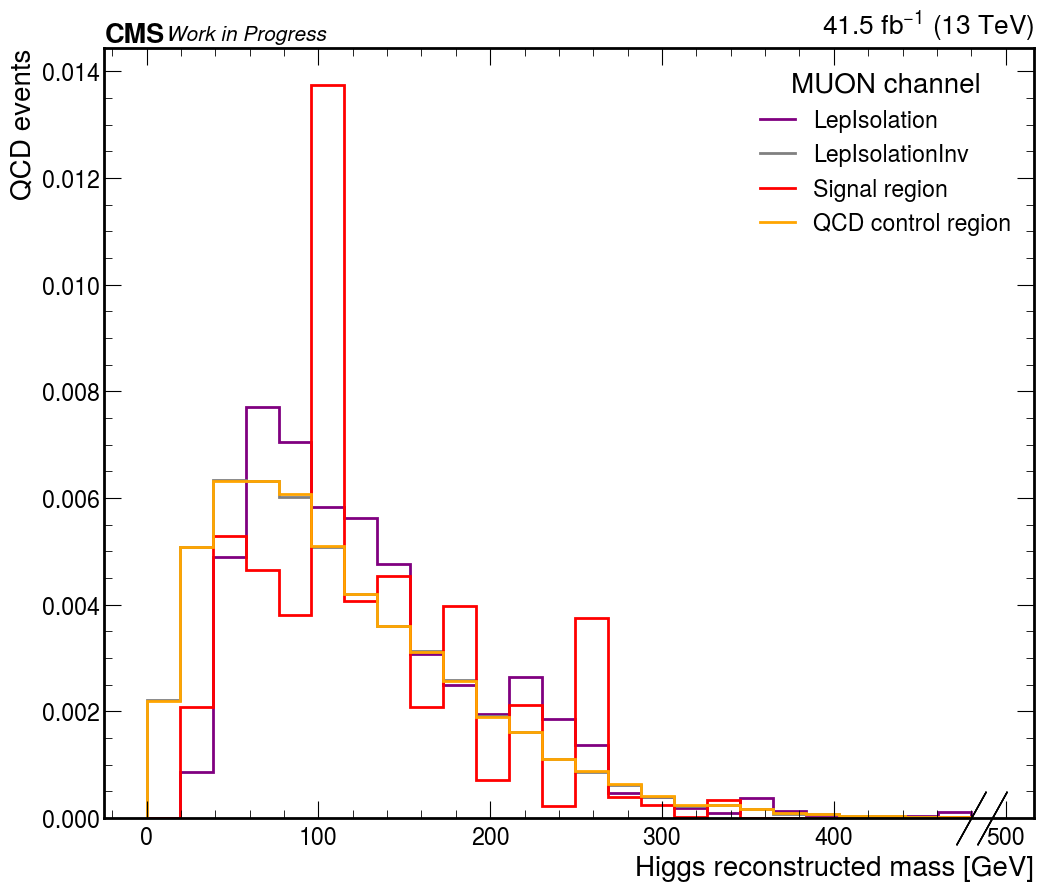

In [526]:
plt.rcParams.update({"font.size": 20})

############################## args up to you
sample = "QCD"    # optios are ["HWW", "WJetsLNu", "QCD", "TTbar"]
regions = [
    "LepIsolation",    
    "LepIsolationInv",
    "Signal region",
    "QCD control region",  
#     "WJets control region",
#     "TTbar control region",
    
#     "QCD old samples",
#     "QCD new samples",    
]       

##############################
        
var = "rec_higgs_m"
# var = "fj_ParticleNet_mass"

# make histogram
h = hist2.Hist(
    hist2.axis.Regular(25, 0, 480, name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
    hist2.axis.StrCategory([], name="region", growth=True),
)    

for year in years:
    for ch in channels:
    
        for region in regions:

            df = events_dict[region][year][ch][sample]

            h.fill(
                var=df[var],
                region=region,
                weight=df["event_weight"]
            )
            
            
# plot histogram
fig, ax = plt.subplots(figsize=(12, 10))

for region in regions:
    hep.histplot(
        h[{"region": region}],
        ax=ax,
        label=region,
        linewidth=2,
        density=True,
        color=color_dict[region]
    )

ax.set_ylabel(f"{sample} events");  

# ax.set_yscale("log")

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

if len(channels)==1:
    ax.legend(title=f"{nice_ch[ch]} channel")
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep14/{var}_{sample}_{ch}.pdf")
else:
    ax.legend()
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep14/{var}_{sample}.pdf")    

In [539]:
events_dict.keys()

dict_keys(['Signal region', 'QCD control region'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


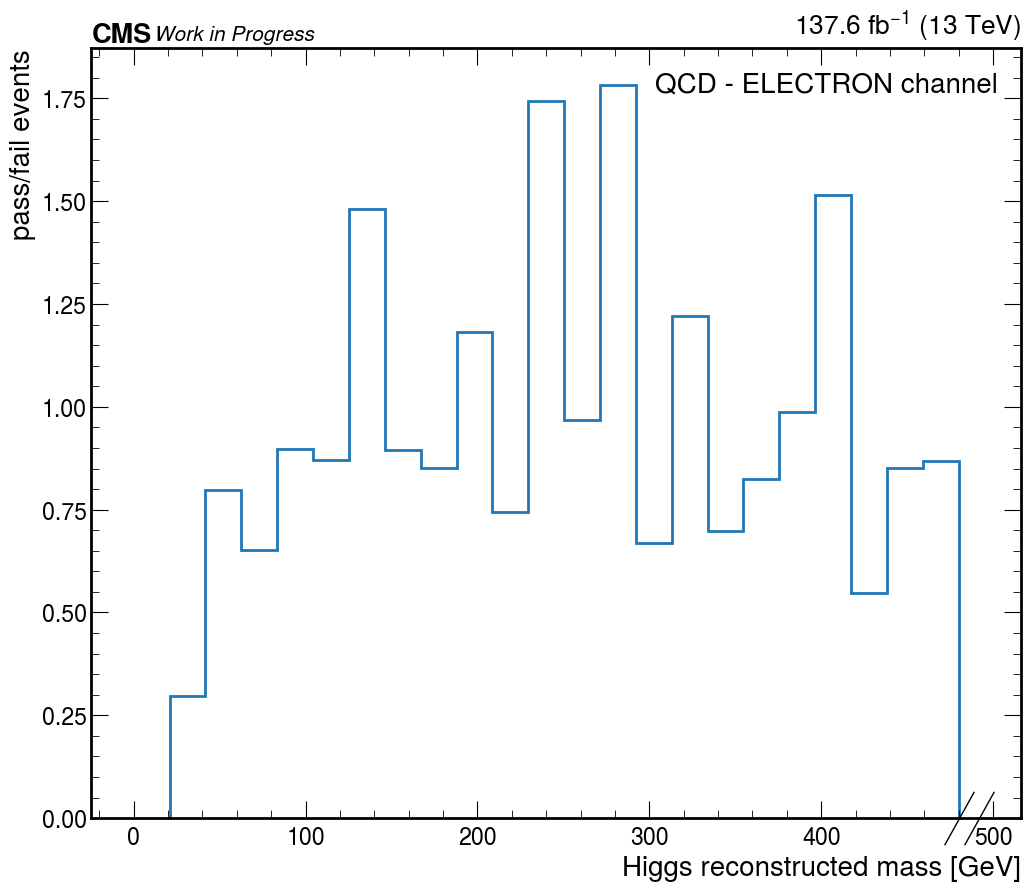

In [593]:
plt.rcParams.update({"font.size": 20})

############################## args up to you
sample = "QCD"    # optios are ["HWW", "WJetsLNu", "QCD", "TTbar"]
regions = [
    "Signal region",
    "QCD control region",  
#     "WJets control region",
#     "TTbar control region",
]       

##############################
        
var = "rec_higgs_m"
# var = "fj_ParticleNet_mass"

# make histogram
h = hist2.Hist(
    hist2.axis.Regular(23, 0, 480, name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
    hist2.axis.StrCategory([], name="region", growth=True),
)    

for year in years:
    for ch in channels:
    
        for region in regions:
            df = events_dict[region][year][ch][sample]

            h.fill(
                var=df[var],
                region=region,
                weight=df["event_weight"]
            )
            
            
# plot histogram
fig, ax = plt.subplots(figsize=(12, 10))

arr = h[{"region": "Signal region"}]
num = (arr/arr.sum())

arr = h[{"region": "QCD control region"}]
den = (arr/arr.sum())

hep.histplot(
    num/den,
    ax=ax,
    linewidth=2,
    density=False,
)

ax.set_ylabel(f"pass/fail events");  

# ax.set_yscale("log")

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

ax.legend(title=f"{sample} - {nice_ch[ch]} channel")
plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep14/ratio_{sample}_{ch}.pdf") 